In [114]:
#nessecary imports
import re
import nltk
import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
from nltk.corpus import stopwords, wordnet
from googletrans import Translator
from matplotlib import style
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Style configuration
style.use('ggplot')


In [115]:
# Load the IMDb reviews dataset
data = tfds.load('imdb_reviews')
data_clean = tfds.load('imdb_reviews')

# Convert the data into pandas DataFrame and decode bytes to string
train_df = tfds.as_dataframe(data['train'])
test_df = tfds.as_dataframe(data['test'])

train_df['text'] = train_df['text'].apply(lambda x: x.decode('utf-8'))
test_df['text'] = test_df['text'].apply(lambda x: x.decode('utf-8'))

# sentiments = labels
# reviews = text

In [116]:
train_df.head()

label                                               text
0      0  This was an absolutely terrible movie. Don't b...
1      0  I have been known to fall asleep during films,...
2      0  Mann photographs the Alberta Rocky Mountains i...
3      1  This is the kind of film for a snowy Sunday af...
4      1  As others have mentioned, all the women that g...

In [117]:
test_df.head()

label                                               text
0      1  There are films that make careers. For George ...
1      1  A blackly comic tale of a down-trodden priest,...
2      0  Scary Movie 1-4, Epic Movie, Date Movie, Meet ...
3      0  Poor Shirley MacLaine tries hard to lend some ...
4      1  As a former Erasmus student I enjoyed this fil...

In [118]:
# add to one dataframe
frames = [train_df, test_df]
imdb_data = pd.concat(frames)

In [119]:
imdb_data.shape

(50000, 2)

In [120]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50000 non-null  int64 
 1   text    50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Text(0.5, 1.0, 'Sentiment distribution')

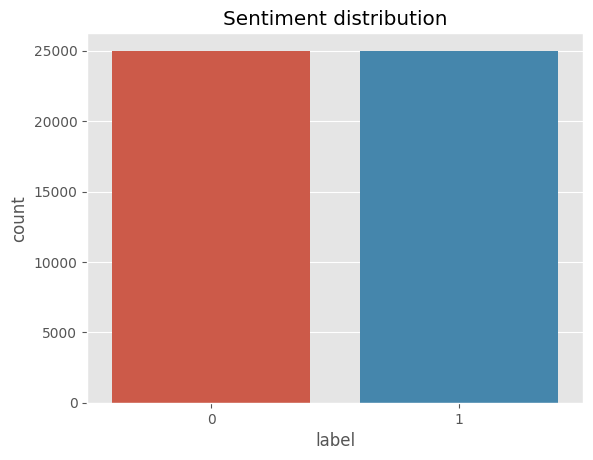

In [121]:
#plot to see the distribution of the sentiment labels
sns.countplot(x='label', data=imdb_data)
plt.title("Sentiment distribution")

In [122]:
#function to count words
def no_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [123]:
#add word count to dataset
imdb_data['word count'] = imdb_data['text'].apply(no_of_words)

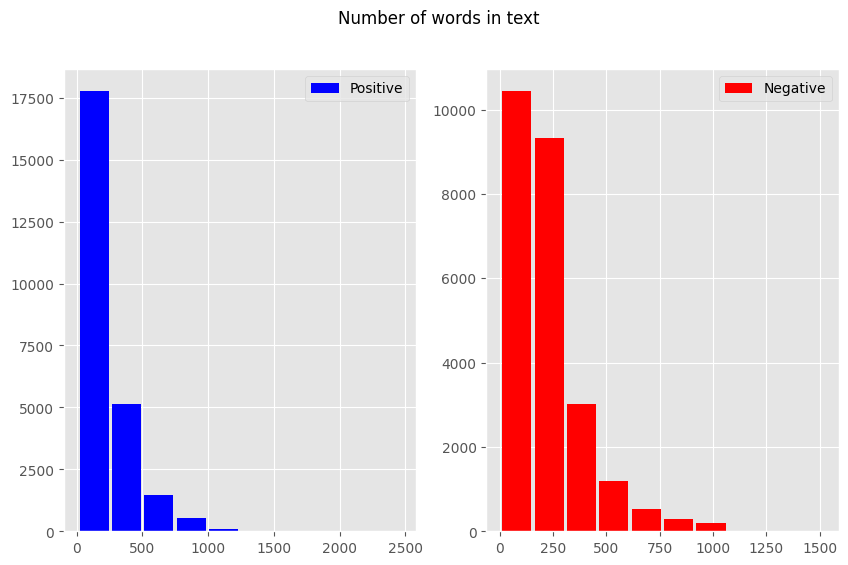

In [124]:
# plot the distribution of the number of words in the reviews
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(imdb_data[imdb_data['label'] == 1]['word count'], label='Positive', color='blue', rwidth=0.9);
ax[0].legend(loc='upper right');
ax[1].hist(imdb_data[imdb_data['label'] == 0]['word count'], label='Negative', color='red', rwidth=0.9);
ax[1].legend(loc='upper right');
fig.suptitle("Number of words in text")
plt.show()



In [125]:
# set positive and negative reviews
positive_reviews = imdb_data[imdb_data['label'] == 1]
negative_review = imdb_data[imdb_data['label'] == 0]

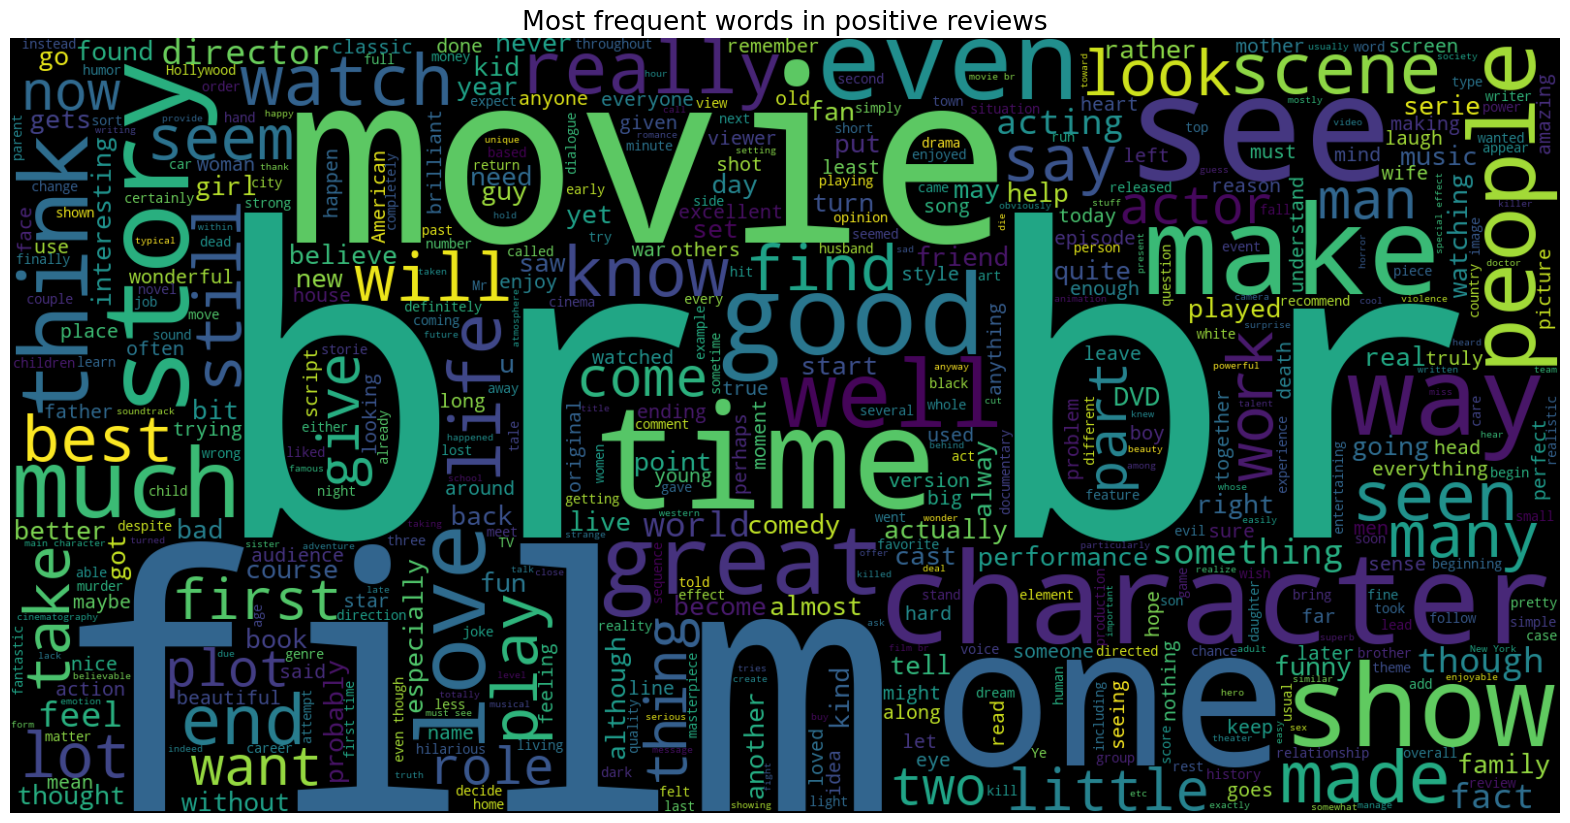

In [126]:
# show the most frequent words in positive reviews
text = ' '.join([word for word in positive_reviews['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

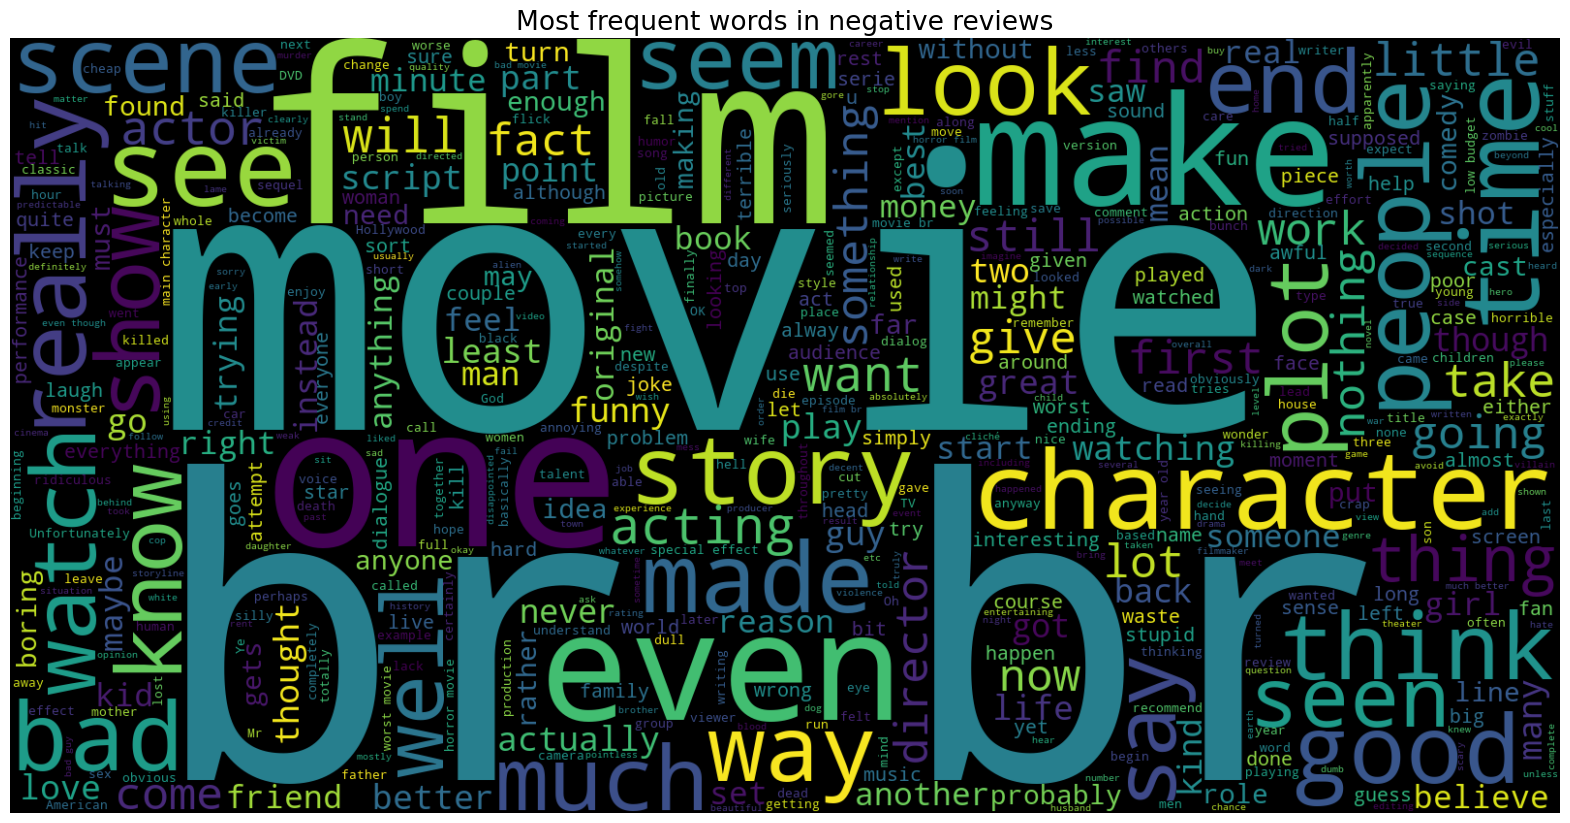

In [127]:
# show the most frequent words in negative reviews
text = ' '.join([word for word in negative_review['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negative reviews', fontsize = 19)
plt.show()

### Clean the Reviews (text) to show the same Vizualisations with "clean" data

In [128]:
# Defining our preprocessing function
lemmatizer = WordNetLemmatizer()
cachedStopWords = stopwords.words("english")
exclude_stopword = {'not', 'against', 'nor', 'no'}
stop_words = ([word for word in cachedStopWords if word not in exclude_stopword])


def preprocess_data(dataframe):
    # HTML Tags removal
    dataframe['text'] = dataframe['text'].apply(lambda words: re.sub('<[^<]+?>', '', words))

    # Lower case conversion
    dataframe['text'] = dataframe['text'].apply(lambda words: words.lower())

    # Word Tokenization
    dataframe['text'] = dataframe['text'].apply(word_tokenize)

    # Punctuation removal
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if not x in punctuation])

    # Number removal
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if not x.isdigit()])

    # Stopword removal
    dataframe['text'] = dataframe['text'].apply(lambda words: [x for x in words if x not in stop_words])

    # Lemmatization
    dataframe['text'] = dataframe['text'].apply(lambda words: [lemmatizer.lemmatize(x) for x in words])

    # Join again
    dataframe['text'] = dataframe['text'].apply(lambda words: " ".join(words))

    return dataframe

In [129]:
# use preprocessing function to clean reviews and add a column with the number of words in each review
preprocess_data(imdb_data)
imdb_data['word count clean'] = imdb_data['text'].apply(no_of_words)


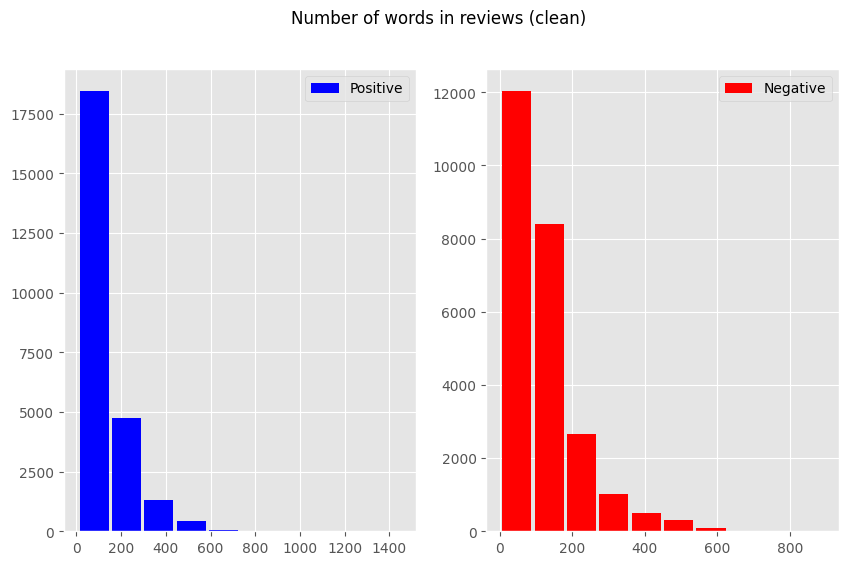

In [130]:
# plot the distribution of the number of words in the reviews
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(imdb_data[imdb_data['label'] == 1]['word count clean'], label='Positive', color='blue', rwidth=0.9);
ax[0].legend(loc='upper right');
ax[1].hist(imdb_data[imdb_data['label'] == 0]['word count clean'], label='Negative', color='red', rwidth=0.9);
ax[1].legend(loc='upper right')
fig.suptitle("Number of words in reviews (clean)")
plt.show()



In [131]:
# set positive and negative reviews for clean data
positive_reviews_c = imdb_data[imdb_data['label'] == 1]
negative_review_c = imdb_data[imdb_data['label'] == 0]

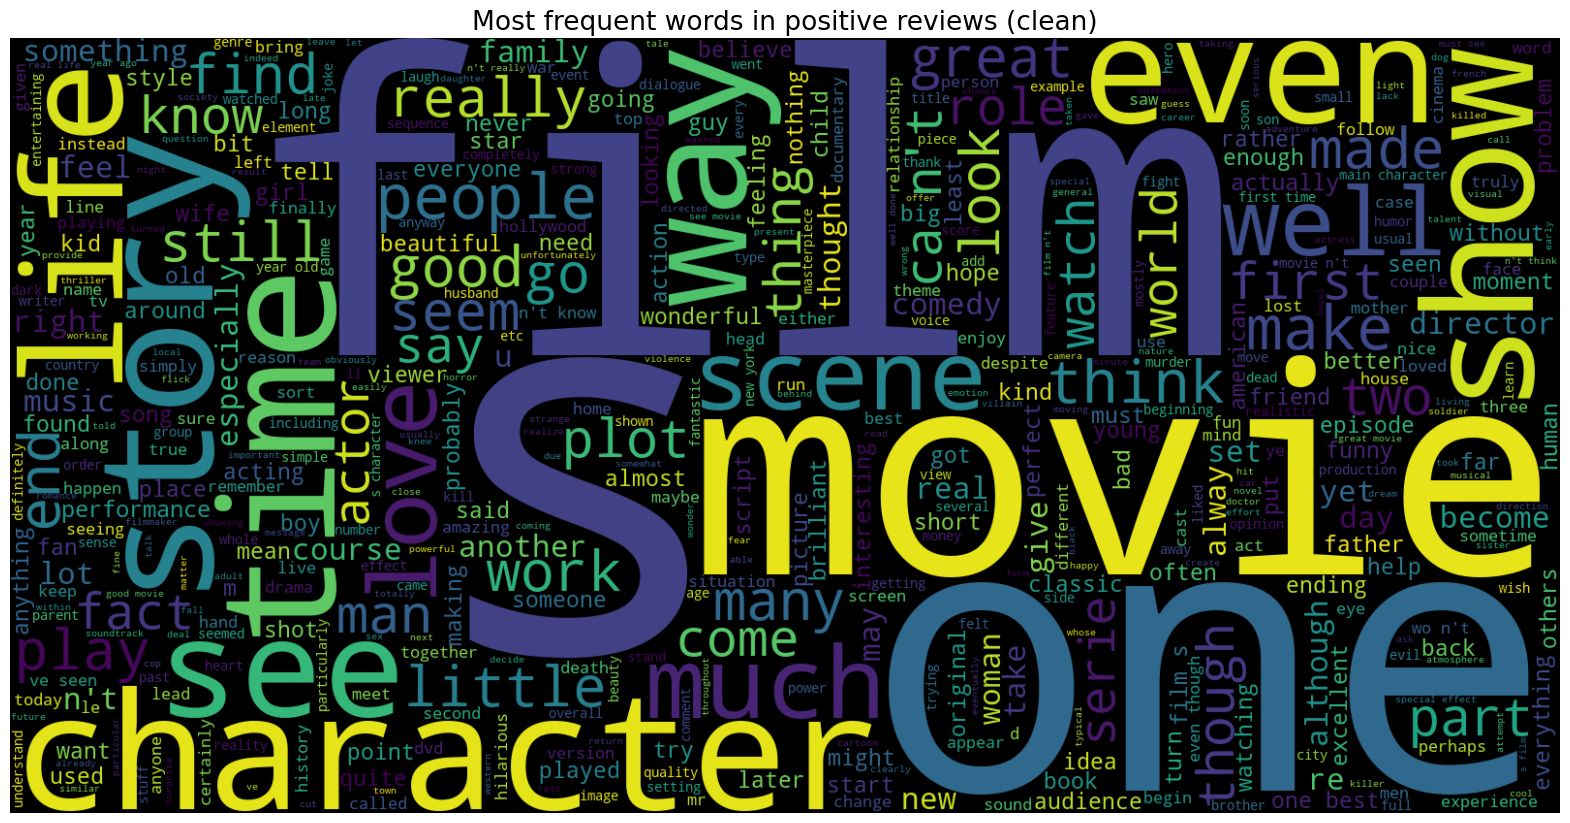

In [132]:
# show the most frequent words in clean positive reviews
text = ' '.join([word for word in positive_reviews_c['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews (clean)', fontsize = 19)
plt.show()

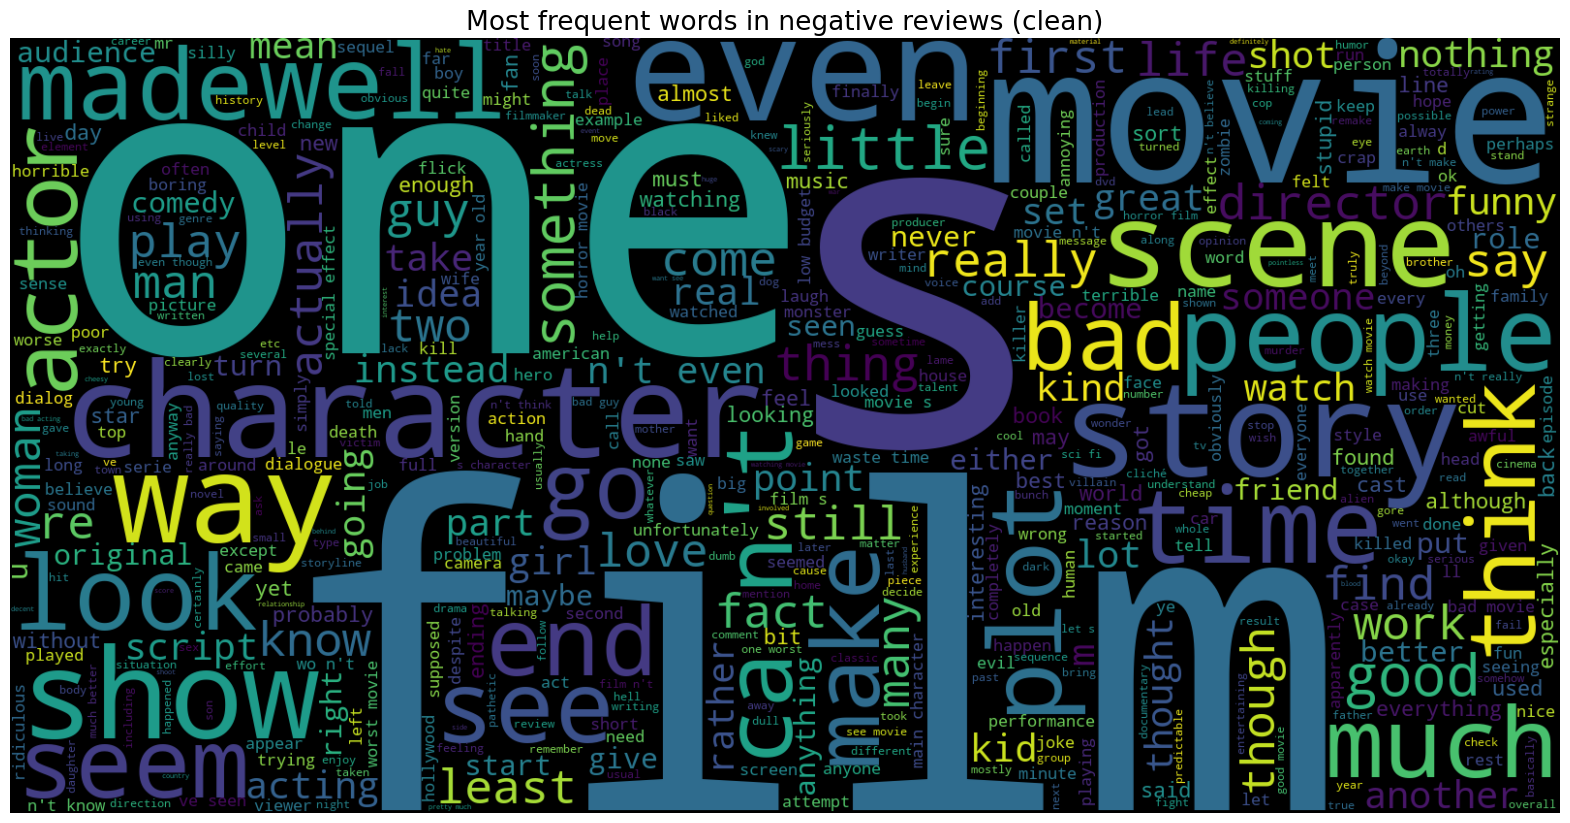

In [133]:
# show the most frequent words in clean negative reviews
text = ' '.join([word for word in negative_review_c['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negative reviews (clean)', fontsize = 19)
plt.show()